## ☁️ Connect G-Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/Homework 2 AN2DL condivisa/Attention + PSPNet/Best + FullData Corretto

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1SjZ_-XjkG_FsuR9orhSxIGp-dNxNdzS1/Homework 2 AN2DL condivisa/Attention + PSPNet/Best + FullData Corretto


## ⚒️ Import libraries


In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers, Model, regularizers
from keras.layers import Add, Activation, Multiply, BatchNormalization, Dropout

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set_style('white')

%matplotlib inline

2.17.1


In [3]:
# Seed for reproducibility
seed = 42

# Load the dataset
data = np.load("/gdrive/My Drive/Homework 2 AN2DL condivisa/Datasets/Dataset_BigRock_Augmented.npz")

X_train = data["training_set"][0, :]
y_train = data["training_set"][1, :]
X_test = data["test_set"]

In [4]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")

train_img, val_img, train_lbl, val_lbl = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")

del X_train, y_train

Splitting data...
Data splitted!

Number of images:
Train: 12704
Validation: 1412


## 📈 Parameters & Network

In [5]:
# Set batch size for training
BATCH_SIZE = 16

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set class weights for the loss function
weights = [0., 0.25, 0.25, 0.25, 0.25]

# Set early stopping patience threshold
PATIENCE = 20

# Set maximum number of training epochs
EPOCHS = 400

# Number of classes
NUM_CLASSES = 5

In [6]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [7]:
# Create the datasets
print("Creating datasets...")

train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128)
Images shape: (16, 64, 128)
Labels shape: (16, 64, 128)
Labels dtype: <dtype: 'float64'>


In [8]:
def attention_gate_refined(x, g, inter_channels):
    """
    Enhanced Attention Gate with normalization and gating improvements.
    x: Encoder feature map.
    g: Decoder feature map.
    inter_channels: Number of intermediate channels in the attention mechanism.
    """
    theta_x = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)
    theta_x = BatchNormalization()(theta_x)

    phi_g = layers.Conv2D(inter_channels, (1, 1), padding='same')(g)
    phi_g = BatchNormalization()(phi_g)

    f = Add()([theta_x, phi_g])
    f = Activation('relu')(f)

    psi = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(f)

    return Multiply()([x, psi])

In [9]:
def PSPNet_plus_attention(input_shape=(64, 128, 1), num_classes=5):

    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Encoder
    down1 = layers.Conv2D(64, (3, 3), padding="same")(inputs)
    down1 = layers.BatchNormalization()(down1)
    down1 = layers.Activation('relu')(down1)

    down1 = layers.Conv2D(64, (3, 3), padding="same")(down1)
    down1 = layers.BatchNormalization()(down1)
    down1_gate = layers.Activation('relu')(down1)

    down2 = layers.MaxPooling2D((2, 2))(down1_gate)

    down2 = layers.Conv2D(128, (3, 3), padding="same")(down2)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.Activation('relu')(down2)

    down2 = layers.Conv2D(128, (3, 3), padding="same")(down2)
    down2 = layers.BatchNormalization()(down2)
    down2_gate = layers.Activation('relu')(down2)

    down3 = layers.MaxPooling2D((2, 2))(down2_gate)

    down3 = layers.Conv2D(256, (3, 3), padding="same")(down3)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.Activation('relu')(down3)

    down3 = layers.Conv2D(256, (3, 3), padding="same")(down3)
    down3 = layers.BatchNormalization()(down3)
    down3_gate = layers.Activation('relu')(down3)

    down4 = layers.MaxPooling2D((2, 2))(down3_gate)

    # Bottleneck
    pool_sizes=[1, 2, 4, 8]
    pooled_outputs = []

    for pool_size in pool_sizes:

        # Apply pooling
        pooled = layers.AveragePooling2D(pool_size)(down4)

        # 1x1 convolution to reduce dimensions
        pooled = layers.Conv2D(256, (1, 1), padding="same", activation="relu")(pooled)

        # 3x3 convolution
        pooled = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(pooled)

        # Calculate the target size for upsampling
        pooled = layers.UpSampling2D(size=(down4.shape[1] // pooled.shape[1], down4.shape[2] // pooled.shape[2]))(pooled)

        # Append to list
        pooled_outputs.append(pooled)

    # Additive fusion
    PSP_output = layers.Add()([down4] + pooled_outputs)

    # Decoder
    up3 = layers.UpSampling2D((2, 2), interpolation='bilinear')(PSP_output)

    gate_3 = attention_gate_refined(down3_gate, up3, inter_channels = 256)
    up3 = layers.Concatenate()([up3, gate_3])

    up3 = layers.Conv2D(256, (3, 3), padding="same")(up3)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.Activation('relu')(up3)

    up3 = layers.Conv2D(256, (3, 3), padding="same")(up3)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.Activation('relu')(up3)

    up2 = layers.UpSampling2D((2, 2), interpolation='bilinear')(up3)

    gate_2 = attention_gate_refined(down2_gate, up2, inter_channels = 128)
    up2 = layers.Concatenate()([up2, gate_2])

    up2 = layers.Conv2D(128, (3, 3), padding="same")(up2)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.Activation('relu')(up2)

    up2 = layers.Conv2D(128, (3, 3), padding="same")(up2)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.Activation('relu')(up2)

    up1 = layers.UpSampling2D((2, 2), interpolation='bilinear')(up2)

    gate_1 = attention_gate_refined(down1_gate, up1, inter_channels = 128)
    up1 = layers.Concatenate()([up1, gate_1])

    up1 = layers.Conv2D(64, (3, 3), padding="same")(up1)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.Activation('relu')(up1)

    up1 = layers.Conv2D(64, (3, 3), padding="same")(up1)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.Activation('relu')(up1)

    # Output layer for multi-class
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(up1)


    return Model(inputs, outputs)

In [10]:
def focal_loss(gamma=2.0, alpha=0.25, weights=None, num_classes=5):
    def focal_loss_fixed(y_true, y_pred):
        # Ensure that labels are integers
        y_true = tf.cast(y_true, tf.int32)  # Cast labels to int32

        # Convert labels to one-hot encoding within the loss function
        y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

        # Clip predictions to avoid log(0) errors
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Calculate cross entropy
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)

        # Calculate the modulating factor (1 - p_t)^gamma
        modulating_factor = tf.pow(1. - y_pred, gamma)

        # Apply class weights if provided
        if weights is not None:
            # Convert weights to tensor and ensure correct shape
            class_weights = tf.convert_to_tensor(weights, dtype=tf.float32)

            # Find indices of the true classes
            true_class_indices = tf.argmax(y_true_one_hot, axis=-1)

            # Gather weights for true classes
            class_specific_weights = tf.gather(class_weights, true_class_indices)

            # Expand dims to match the shape of y_pred
            class_specific_weights = tf.expand_dims(class_specific_weights, axis=-1)


            # Apply weights
            weight = alpha * modulating_factor * class_specific_weights
        else:
            # Default focal loss weight if no custom weights are provided
            weight = alpha * modulating_factor

        # Compute focal loss for each class and average
        loss = tf.reduce_sum(weight * cross_entropy, axis=-1)
        return tf.reduce_mean(loss)  # Return the average loss
    return focal_loss_fixed


def SparseCategoricalCrossentropyWithWeights(weights):
    """
    Custom Sparse Categorical Crossentropy with class weights.
    Args:
        weights: List or array of class weights, length = numClasses.
    """
    def loss_fn(y_true, y_pred):
        # Convert y_true to int32 for compatibility
        y_true = tf.cast(y_true, tf.int32)

        # Calculate the standard sparse categorical crossentropy loss
        scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        # Apply class weights
        class_weights = tf.gather(weights, y_true)  # Select weights based on y_true values
        weighted_loss = scce * class_weights

        # Return mean loss
        return tf.reduce_mean(weighted_loss)

    return loss_fn



def combined_loss(y_true, y_pred, num_classes=5, alpha=0.7, beta=0.3):
    """
    A weighted combination of Sparse Categorical Cross Entropy with Weights and Focal Loss for multiclass segmentation.
    """
    # Define weights for SparseCategoricalCrossentropyWithWeights
    weights = [0., 0.25, 0.25, 0.25, 0.25]

    # Compute individual loss values
    loss_fn_value = SparseCategoricalCrossentropyWithWeights(weights)(y_true, y_pred)

    # focal loss
    focal_loss_value = focal_loss(gamma=2.0, alpha=1.0, weights=weights, num_classes=NUM_CLASSES)(y_true, y_pred)

    # Weighted sum of the loss functions
    total_loss = alpha * loss_fn_value + beta * focal_loss_value

    return total_loss

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 128, 64)    │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 128, 64)    │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 64, 128, 64)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 64)    │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 128, 64)    │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 64, 128, 64)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 6,493,320 (24.77 MB)

 Trainable params: 6,487,688 (24.75 MB)

 Non-trainable params: 5,632 (22.00 KB)

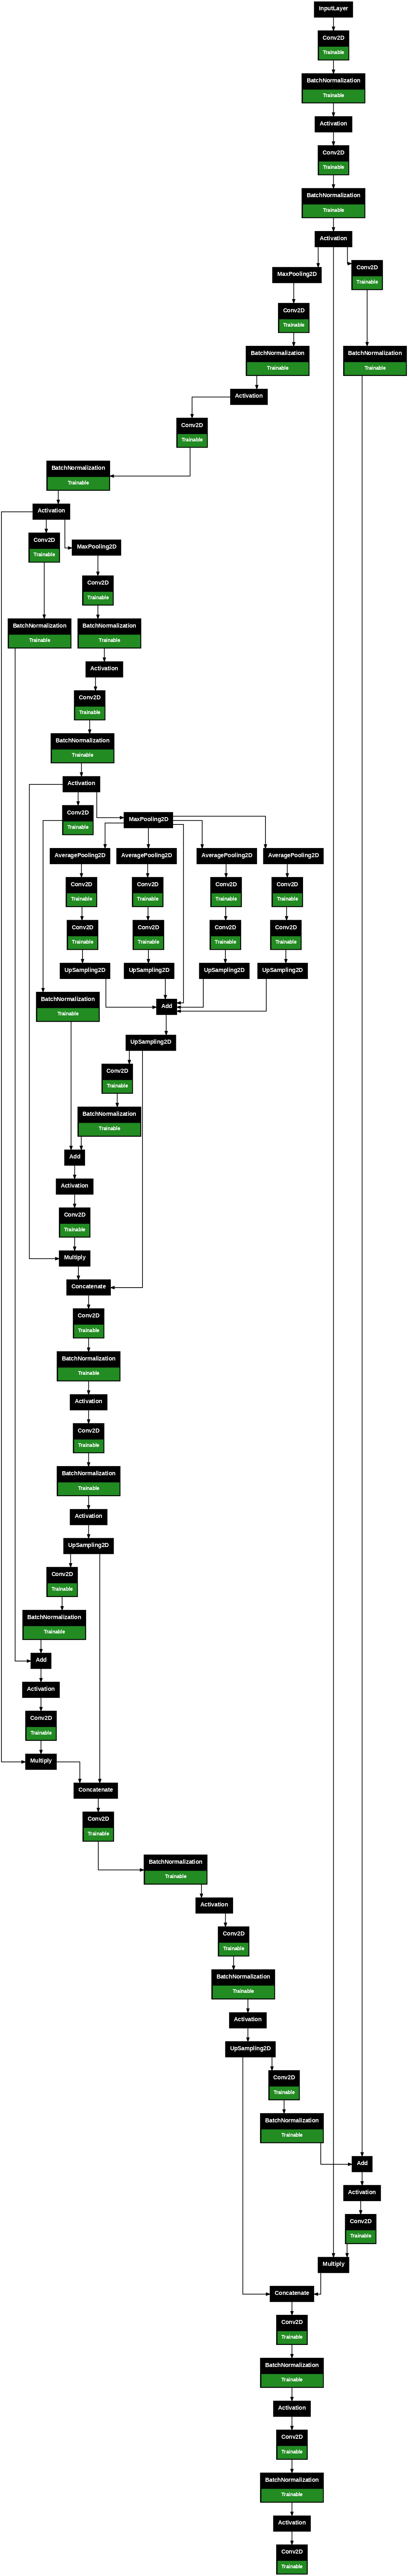

In [11]:
mean_iou = tfk.metrics.MeanIoU(num_classes = NUM_CLASSES, ignore_class=0, sparse_y_pred=False)

# Compile the Model
model = PSPNet_plus_attention(input_shape = (64, 128, 1), num_classes = NUM_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss= combined_loss,
    metrics=['accuracy', mean_iou]
)

model.summary()

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [12]:
def create_segmentation_colormap(num_classes):

    """
    Choosing a linear colormap from a predefined palette
    """
    return plt.cm.inferno(np.linspace(0, 1, num_classes))

def apply_colormap(label):

    """
    Apply the colormap to a label
    Same color for the same class across images
    """

    # Import the colormap
    colormap = create_segmentation_colormap(NUM_CLASSES)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

class VizCallback(tf.keras.callbacks.Callback):

  def __init__(self, image, label):
    super().__init__()
    self.image = image
    self.label = label

  def on_epoch_end(self, epoch, logs = None):

    if epoch % 10 == 0:  # Visualize every 10 epochs

      # Add a new dimension to the tensor (batch processing  expected)
      image = tf.expand_dims(self.image, 0)

      # Prediction
      y_pred = self.model.predict(image, verbose=0)
      y_pred = tf.argmax(y_pred, axis=-1).numpy()

      # Plot
      plt.figure(figsize = (16, 4))

      # Input image
      plt.subplot(1, 3, 1)
      plt.imshow(image[0], cmap='grey')
      plt.title("Input Image")
      plt.axis('off')

      # Ground truth
      plt.subplot(1, 3, 2)
      plt.imshow(self.label, cmap='inferno', vmin=0, vmax=4)
      plt.title("Ground Truth Mask")
      plt.axis('off')

      # Prediction
      plt.subplot(1, 3, 3)
      plt.imshow(y_pred[0], cmap='inferno', vmin=0, vmax=4)
      plt.title("Predicted Mask")
      plt.axis('off')

      plt.tight_layout()
      plt.show()

In [13]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_io_u',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_io_u',
    factor=0.8,
    patience=20,
    min_lr=1e-5,
    verbose=1
)

viz_callback = VizCallback(val_img[42], val_lbl[42])

In [14]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
).history


Epoch 1/400
794/794 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.4868 - loss: 0.1346 - mean_io_u: 0.3917 - val_accuracy: 0.5645 - val_loss: 0.0864 - val_mean_io_u: 0.5153 - learning_rate: 1.0000e-04
Epoch 2/400
794/794 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5911 - loss: 0.0789 - mean_io_u: 0.5492 - val_accuracy: 0.5532 - val_loss: 0.0836 - val_mean_io_u: 0.5204 - learning_rate: 1.0000e-04
Epoch 3/400
794/794 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6155 - loss: 0.0657 - mean_io_u: 0.5934 - val_accuracy: 0.6243 - val_loss: 0.0603 - val_mean_io_u: 0.6250 - learning_rate: 1.0000e-04
Epoch 4/400
794/794 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6343 - loss: 0.0553 - mean_io_u: 0.6266 - val_accuracy: 0.6211 - val_loss: 0.0524 - val_mean_io_u: 0.6204 - learning_rate: 1.0000e-04
Epoch 5/400
794/794 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6397 - loss: 0.0520 - mean_io_u: 0.6361 - val_accuracy: 0.6383 - val_loss: 0.0461 - val_mean_io_u: 0.6489 - learning_ra

In [15]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'PSP_Attention_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 72.88%


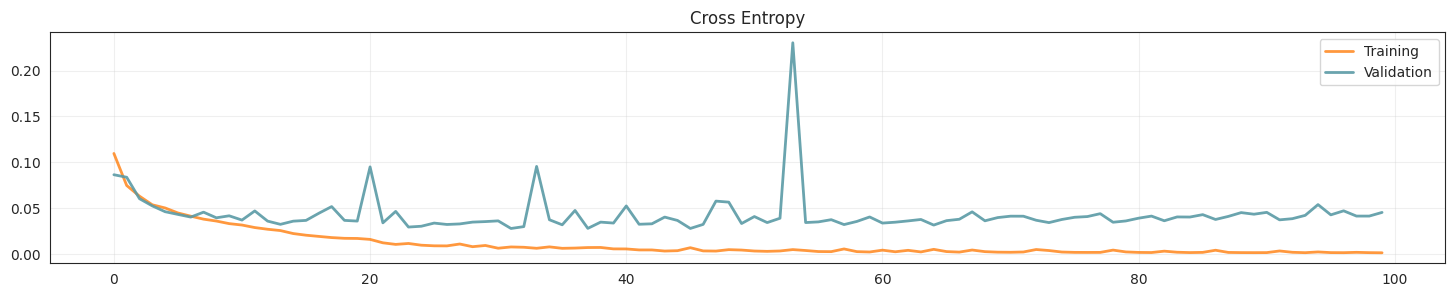

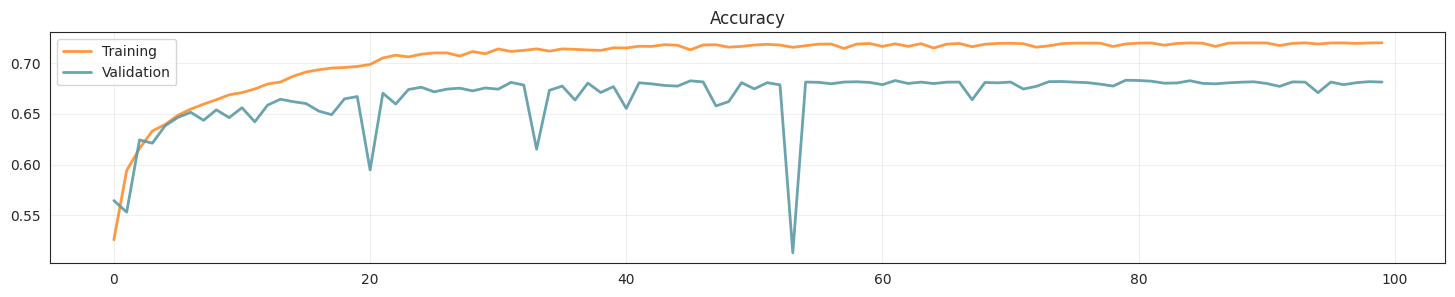

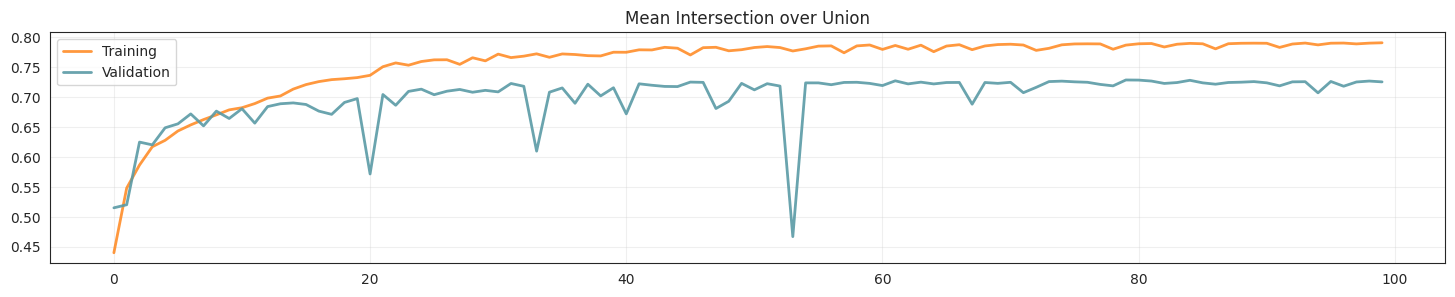

In [16]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 64)  │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 64)  │       36,928 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 64)  │          256 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 64)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 32, 64, 128)  │       73,856 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 32, 64, 128)  │          512 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 32, 64, 128)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 128)  │      147,584 │ activation_2[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 32, 64, 128)  │          512 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_3           │ (None, 32, 64, 128)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_1      

 Total params: 6,493,320 (24.77 MB)

 Trainable params: 6,487,688 (24.75 MB)

 Non-trainable params: 5,632 (22.00 KB)

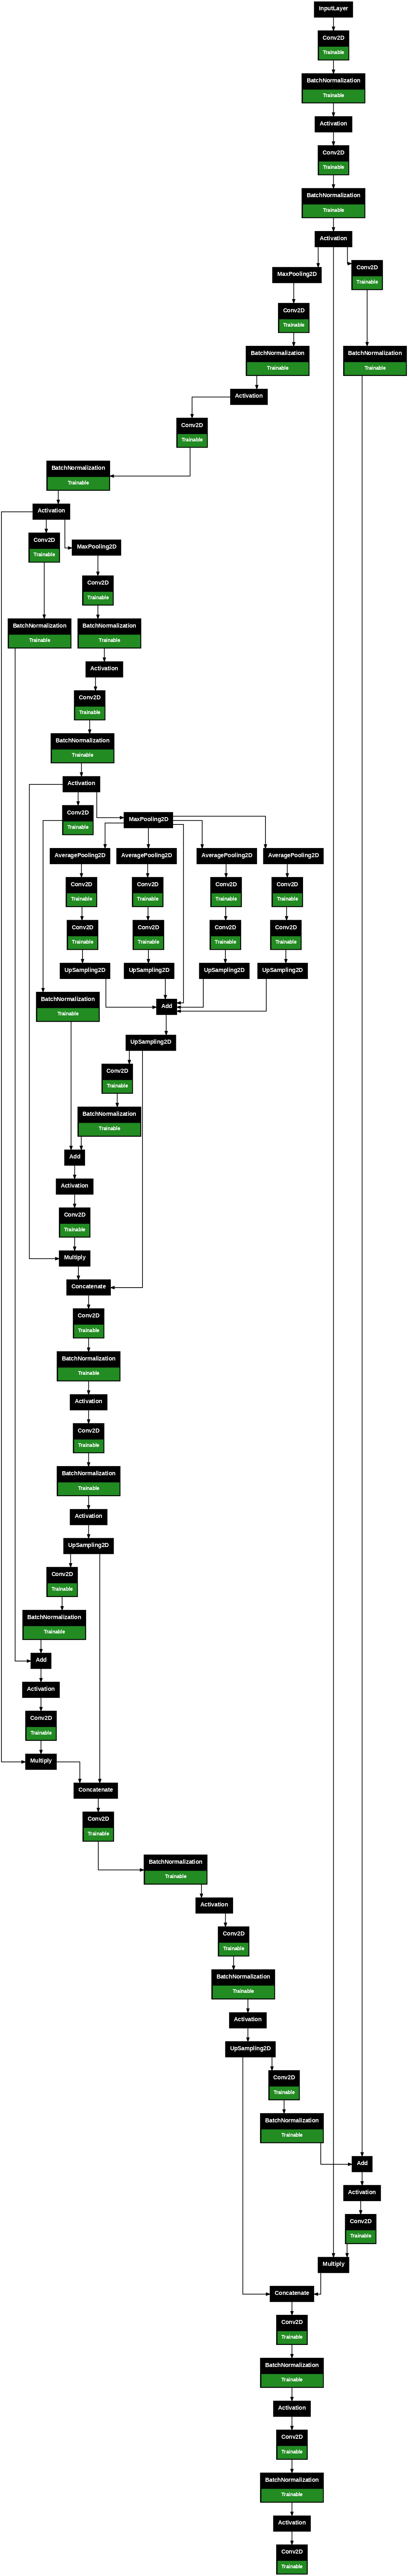

In [19]:
# Load UNet model without compiling
model_filename = 'PSP_Attention_72.88.keras'
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=combined_loss, metrics=["accuracy", mean_iou])

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

Nero Background

Viola Soil

Rosso Bedrock

Arancione Sabbia

Giallino Big Rock

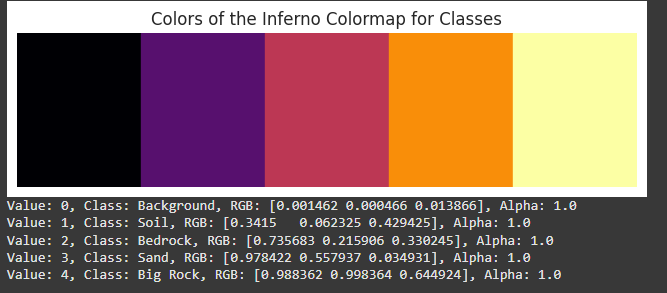

In [23]:
print(model_filename)

PSP_Attention_72.88.keras


In [24]:
# Prediction
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step
Predictions shape: (10022, 64, 128)


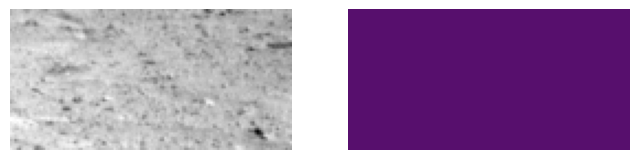

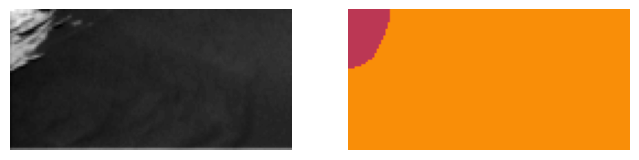

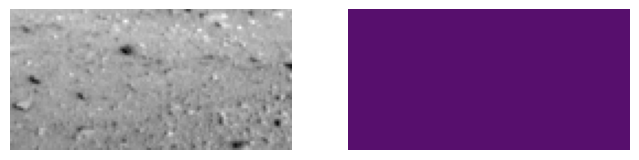

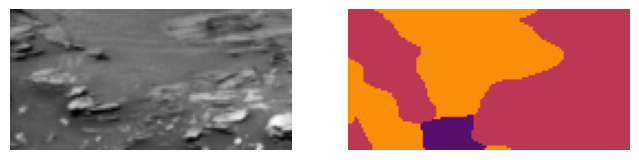

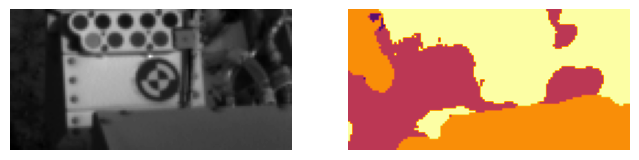

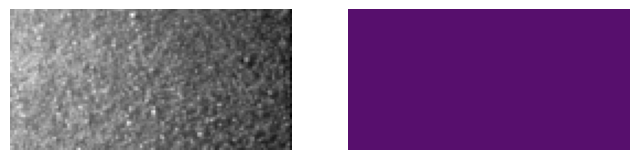

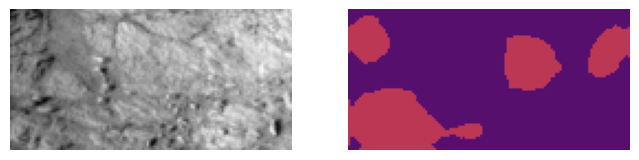

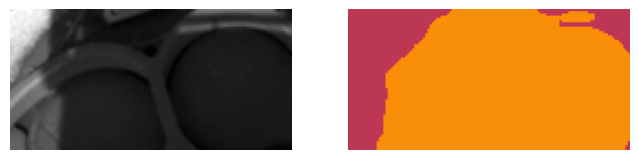

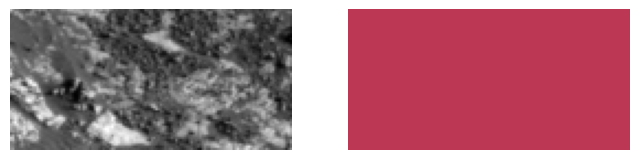

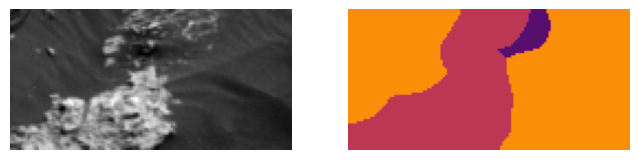

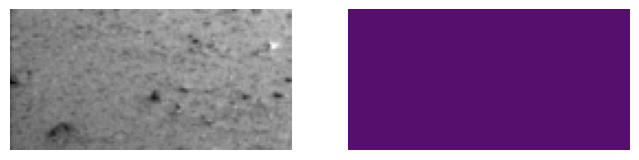

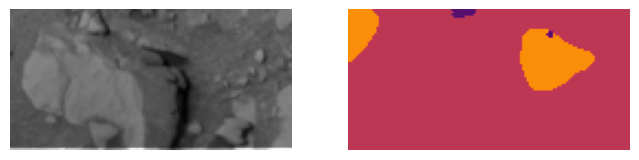

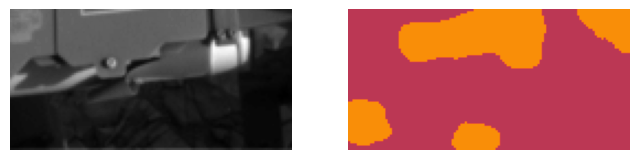

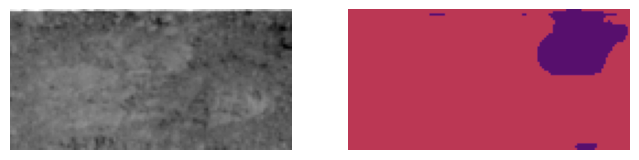

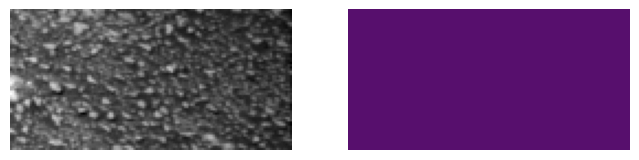

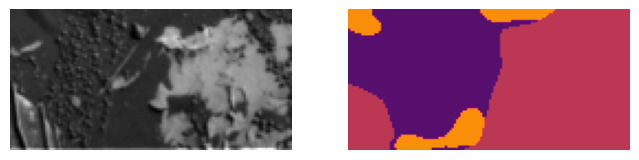

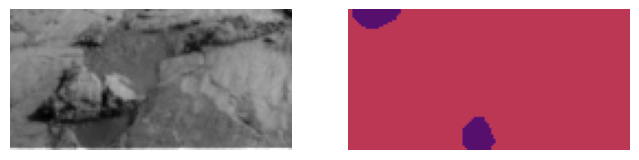

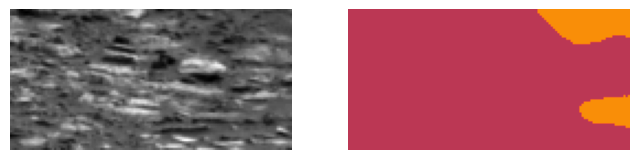

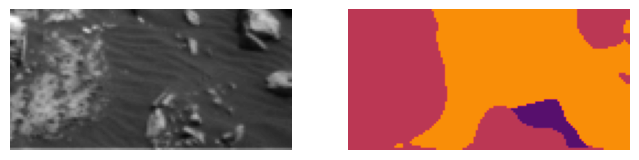

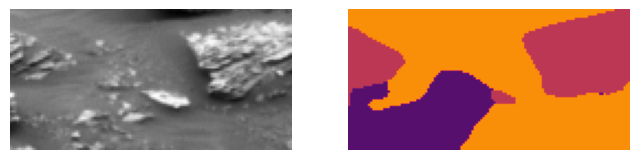

In [26]:
# Plotting some predictions
idx = np.random.randint(0, preds.shape[0], 20)

for i in idx:
  plt.figure(figsize=(8,4))
  plt.subplot(1,2,1)
  plt.imshow(X_test[i], cmap='grey')
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.imshow(preds[i], cmap='inferno', vmin=0, vmax=4)
  plt.axis('off')
plt.show()

In [27]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [28]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>